In [18]:
import pickle
import matplotlib.pyplot as plt
import numpy as np

# Load both LSTM and Transformer results
with open('final_results.pkl', 'rb') as f:
    lstm_results = pickle.load(f)

with open('final_results_transformer.pkl', 'rb') as f:
    transformer_results = pickle.load(f)

print("LSTM results loaded:", list(lstm_results.keys()))
print("Transformer results loaded:", list(transformer_results.keys()))

LSTM results loaded: ['data/dax40', 'data/dji', 'data/ftse100', 'data/sp500']
Transformer results loaded: ['data/dax40', 'data/dji', 'data/ftse100', 'data/sp500']


In [19]:
# Configuration
stocks = ['data/dax40', 'data/dji', 'data/ftse100', 'data/sp500']
windows = [10, 20, 50]

# Helper function to get metrics
def get_final_metrics(results, stock, window):
    """Extract final validation loss and MAE from results"""
    if stock not in results or window not in results[stock]:
        return None, None
    data = results[stock][window]
    val_loss = data['history']['val_loss'][-1]
    val_mae = data['history']['val_mae'][-1]
    return val_loss, val_mae

## 1. Overall Comparison: LSTM vs Transformer

Compare final validation loss and MAE across all stocks and window sizes.

In [20]:
# Create comparison table
print("=" * 80)
print(f"{'Stock':<15} {'Window':<8} {'LSTM Loss':<12} {'Trans Loss':<12} {'LSTM MAE':<12} {'Trans MAE':<12} {'Winner'}")
print("=" * 80)

for stock in stocks:
    for ws in windows:
        lstm_loss, lstm_mae = get_final_metrics(lstm_results, stock, ws)
        trans_loss, trans_mae = get_final_metrics(transformer_results, stock, ws)
        
        if lstm_loss is None or trans_loss is None:
            continue
            
        winner = "LSTM" if lstm_loss < trans_loss else "Transformer"
        print(f"{stock:<15} {ws:<8} {lstm_loss:<12.4f} {trans_loss:<12.4f} {lstm_mae:<12.4f} {trans_mae:<12.4f} {winner}")

print("=" * 80)

Stock           Window   LSTM Loss    Trans Loss   LSTM MAE     Trans MAE    Winner
data/dax40      10       0.0002       0.0055       0.0117       0.0477       LSTM
data/dax40      20       0.0001       0.0015       0.0068       0.0286       LSTM
data/dax40      50       0.0001       0.0025       0.0061       0.0326       LSTM
data/dji        10       0.0000       0.0014       0.0036       0.0285       LSTM
data/dji        20       0.0000       0.0025       0.0051       0.0356       LSTM
data/dji        50       0.0000       0.0048       0.0036       0.0591       LSTM
data/ftse100    10       0.0000       0.0011       0.0028       0.0270       LSTM
data/ftse100    20       0.0000       0.0017       0.0030       0.0257       LSTM
data/ftse100    50       0.0001       0.0009       0.0080       0.0252       LSTM


## 2. Bar Chart: Loss Comparison by Window Size

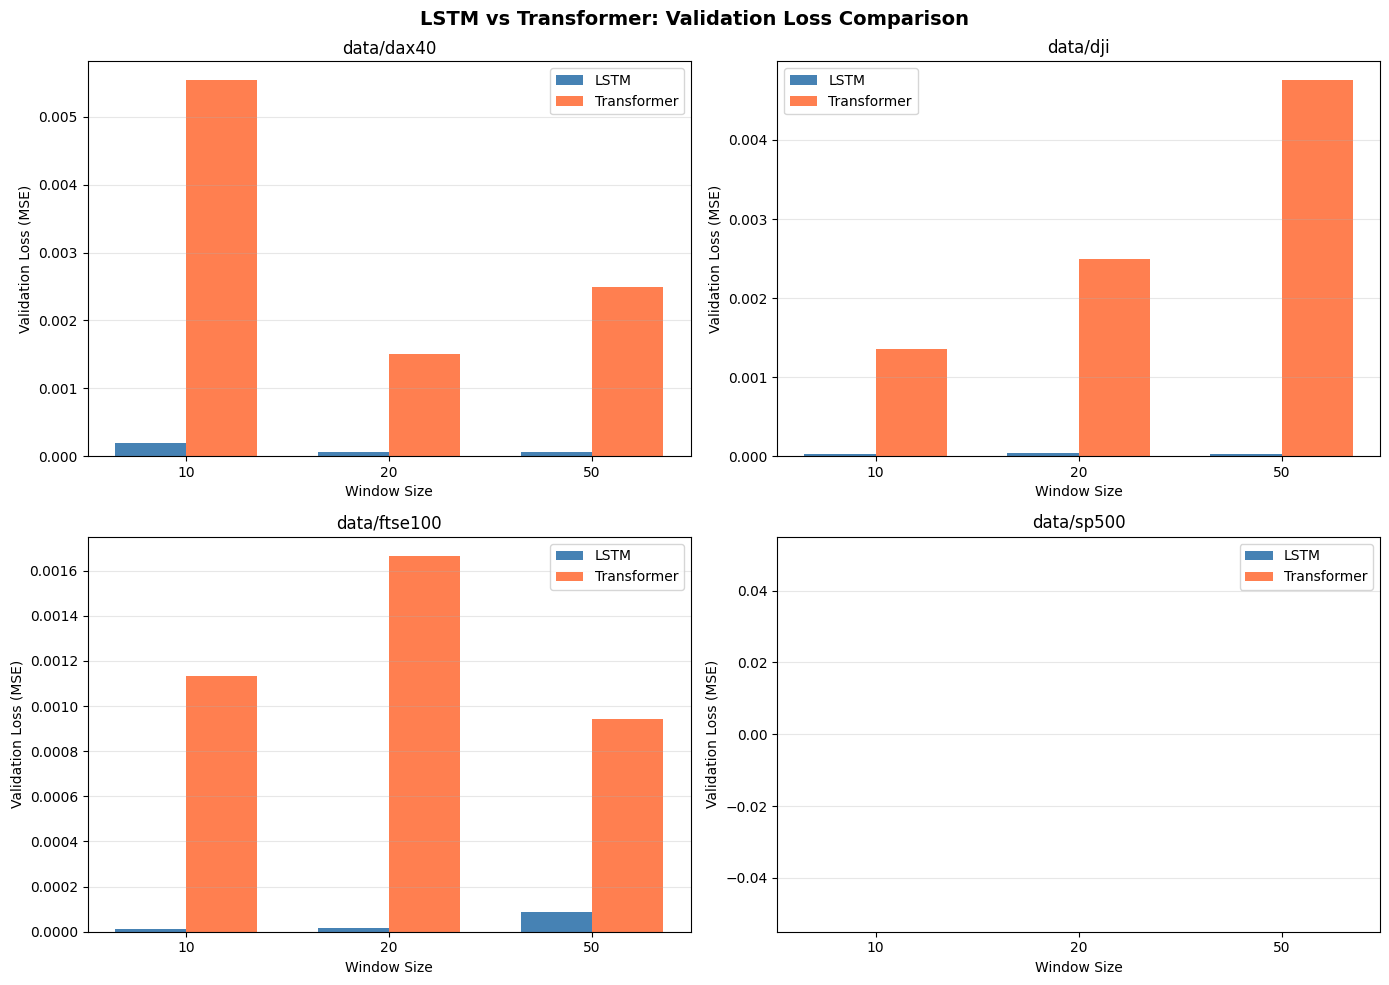

In [21]:
# Bar chart comparison for each stock
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

x = np.arange(len(windows))
width = 0.35

for idx, stock in enumerate(stocks):
    lstm_losses = [get_final_metrics(lstm_results, stock, ws)[0] or 0 for ws in windows]
    trans_losses = [get_final_metrics(transformer_results, stock, ws)[0] or 0 for ws in windows]
    
    ax = axes[idx]
    bars1 = ax.bar(x - width/2, lstm_losses, width, label='LSTM', color='steelblue')
    bars2 = ax.bar(x + width/2, trans_losses, width, label='Transformer', color='coral')
    
    ax.set_xlabel('Window Size')
    ax.set_ylabel('Validation Loss (MSE)')
    ax.set_title(f'{stock}')
    ax.set_xticks(x)
    ax.set_xticklabels(windows)
    ax.legend()
    ax.grid(axis='y', alpha=0.3)

plt.suptitle('LSTM vs Transformer: Validation Loss Comparison', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

## 3. Training Curves: LSTM vs Transformer

Compare training and validation loss curves for both models.

In [22]:
def plot_training_comparison(stock, window):
    """Plot training curves comparison for LSTM and Transformer"""
    lstm_data = lstm_results.get(stock, {}).get(window)
    trans_data = transformer_results.get(stock, {}).get(window)
    
    if lstm_data is None or trans_data is None:
        print(f"Data not available for {stock} window {window}")
        return
    
    fig, axes = plt.subplots(1, 3, figsize=(16, 4))
    
    # Loss curves
    ax1 = axes[0]
    ax1.plot(lstm_data['history']['train_loss'], 'b-', label='LSTM Train', alpha=0.7)
    ax1.plot(lstm_data['history']['val_loss'], 'b--', label='LSTM Val', linewidth=2)
    ax1.plot(trans_data['history']['train_loss'], 'r-', label='Trans Train', alpha=0.7)
    ax1.plot(trans_data['history']['val_loss'], 'r--', label='Trans Val', linewidth=2)
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss (MSE)')
    ax1.set_title('Training & Validation Loss')
    ax1.legend()
    ax1.grid(alpha=0.3)
    
    # MAE curves
    ax2 = axes[1]
    ax2.plot(lstm_data['history']['train_mae'], 'b-', label='LSTM Train', alpha=0.7)
    ax2.plot(lstm_data['history']['val_mae'], 'b--', label='LSTM Val', linewidth=2)
    ax2.plot(trans_data['history']['train_mae'], 'r-', label='Trans Train', alpha=0.7)
    ax2.plot(trans_data['history']['val_mae'], 'r--', label='Trans Val', linewidth=2)
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('MAE')
    ax2.set_title('Training & Validation MAE')
    ax2.legend()
    ax2.grid(alpha=0.3)
    
    # Predictions comparison
    ax3 = axes[2]
    subset = min(100, len(lstm_data['actuals']))
    ax3.plot(lstm_data['actuals'][:subset], 'k-', label='Actual', linewidth=2)
    ax3.plot(lstm_data['predictions'][:subset], 'b--', label='LSTM Pred', alpha=0.8)
    ax3.plot(trans_data['predictions'][:subset], 'r--', label='Trans Pred', alpha=0.8)
    ax3.set_xlabel('Time Steps')
    ax3.set_ylabel('Normalized Price')
    ax3.set_title(f'Predictions (First {subset} samples)')
    ax3.legend()
    ax3.grid(alpha=0.3)
    
    plt.suptitle(f'{stock} - Window {window}: LSTM vs Transformer', fontsize=12, fontweight='bold')
    plt.tight_layout()
    plt.show()

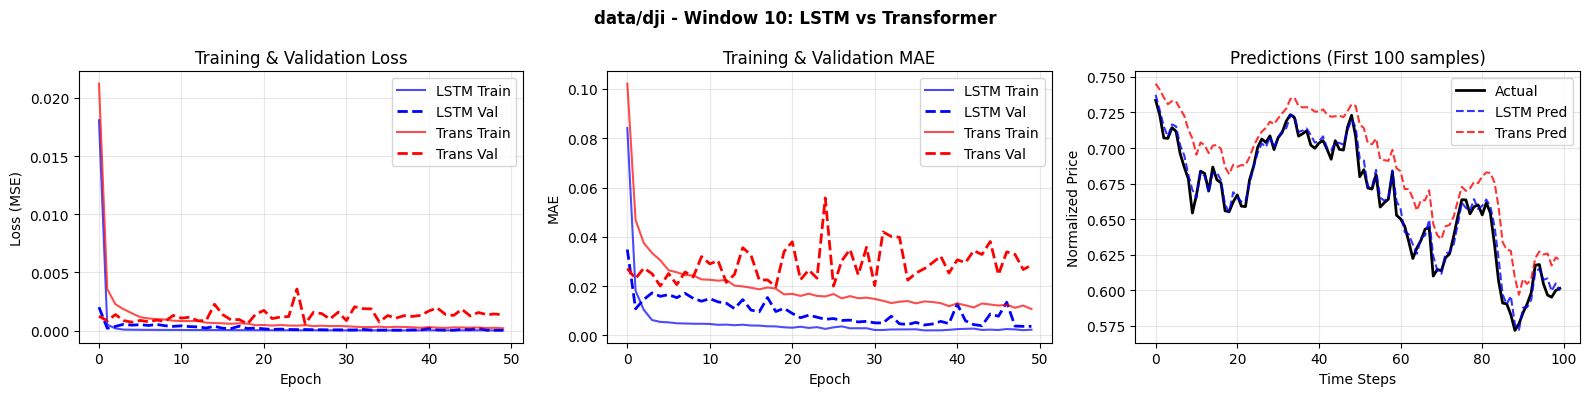

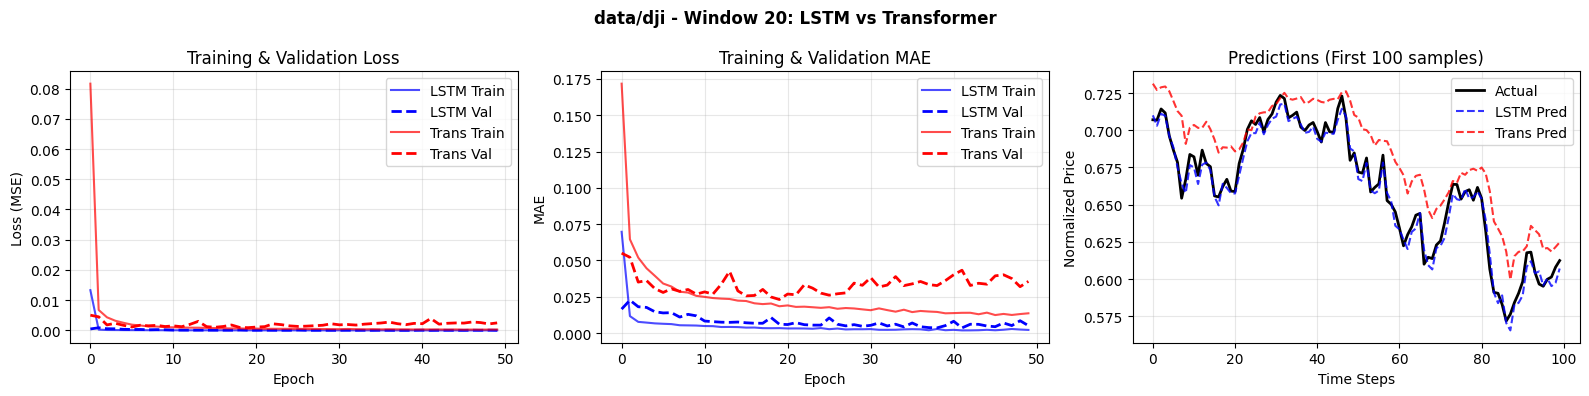

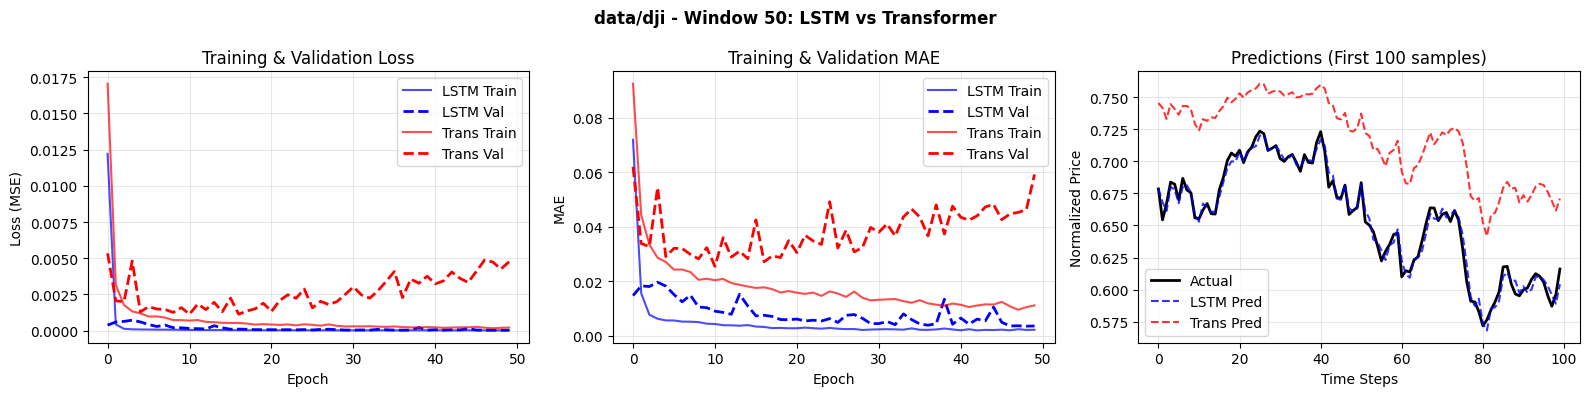

In [23]:
# Plot comparison for DJI with different window sizes
for ws in windows:
    plot_training_comparison('data/dji', ws)

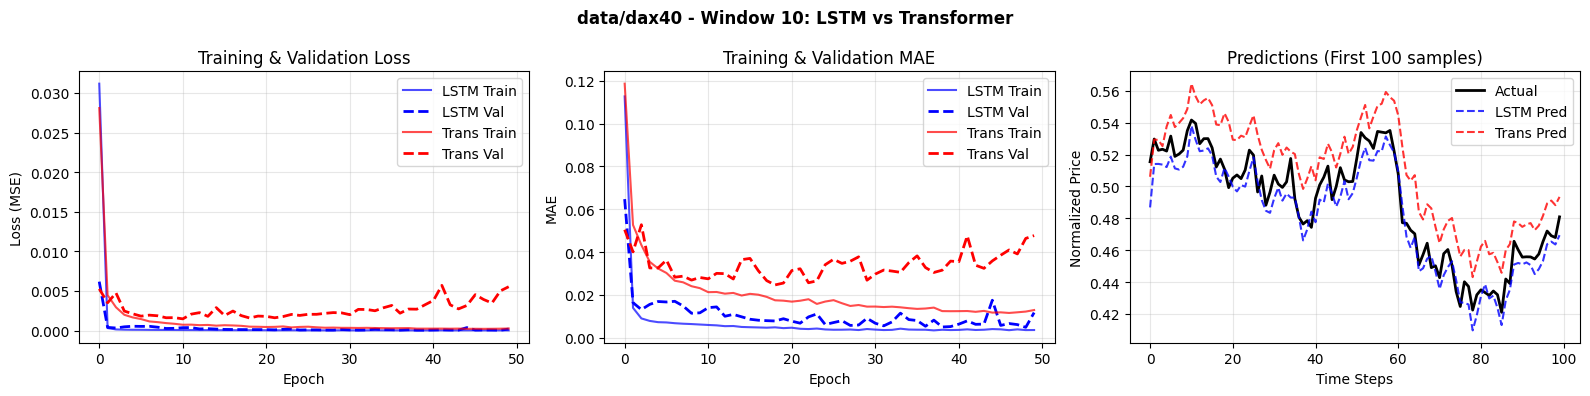

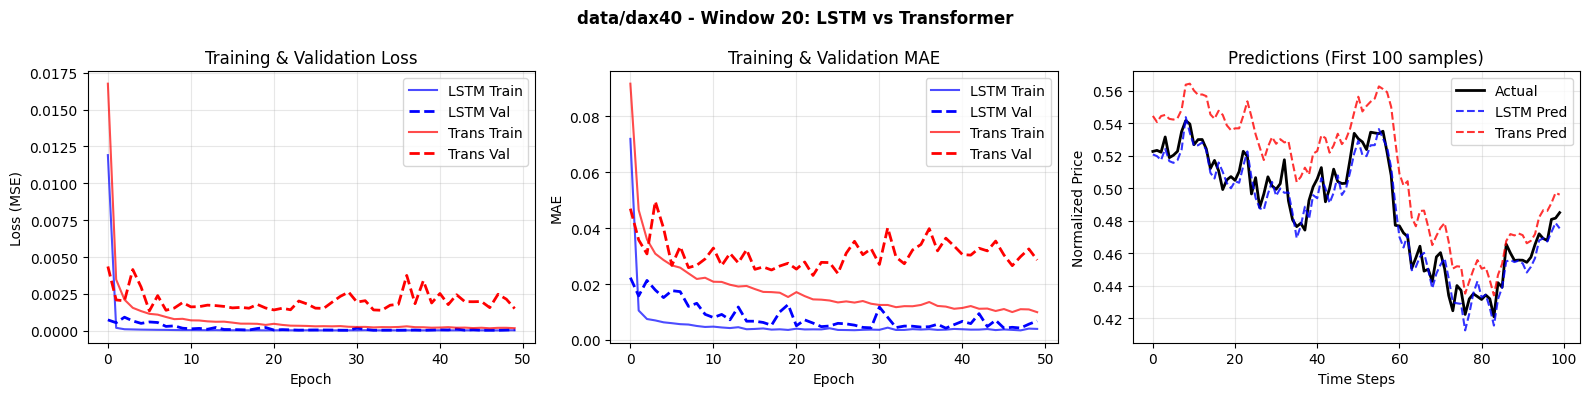

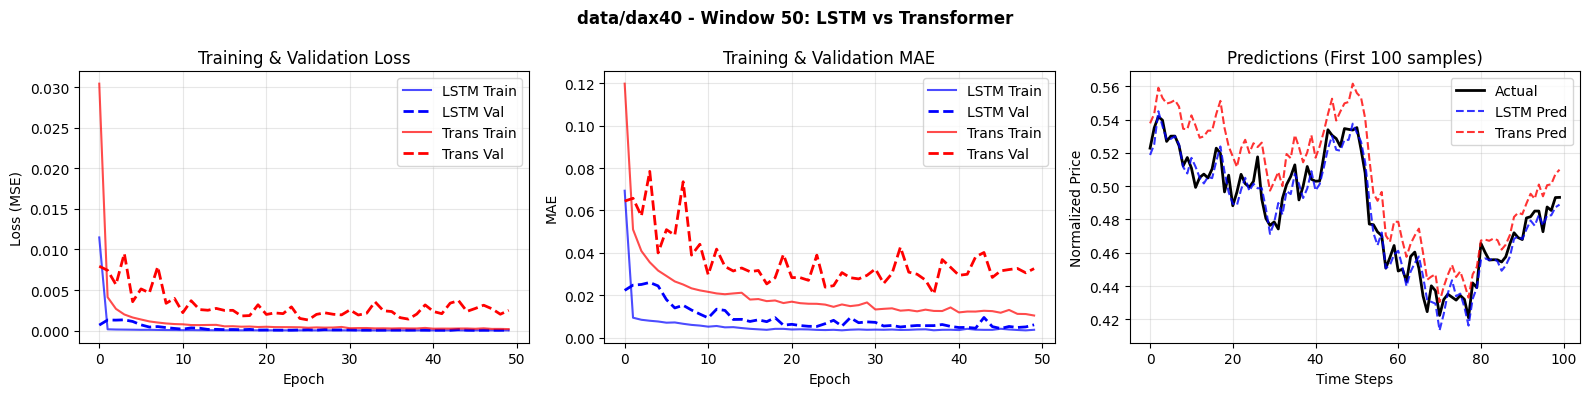

In [24]:
# Plot comparison for DAX40 with different window sizes
for ws in windows:
    plot_training_comparison('data/dax40', ws)

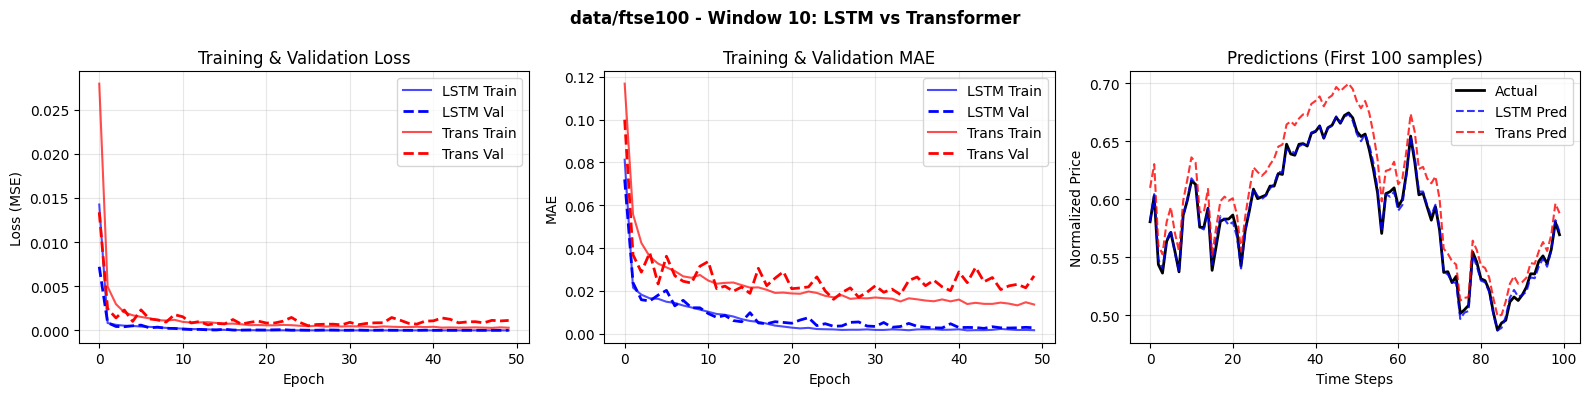

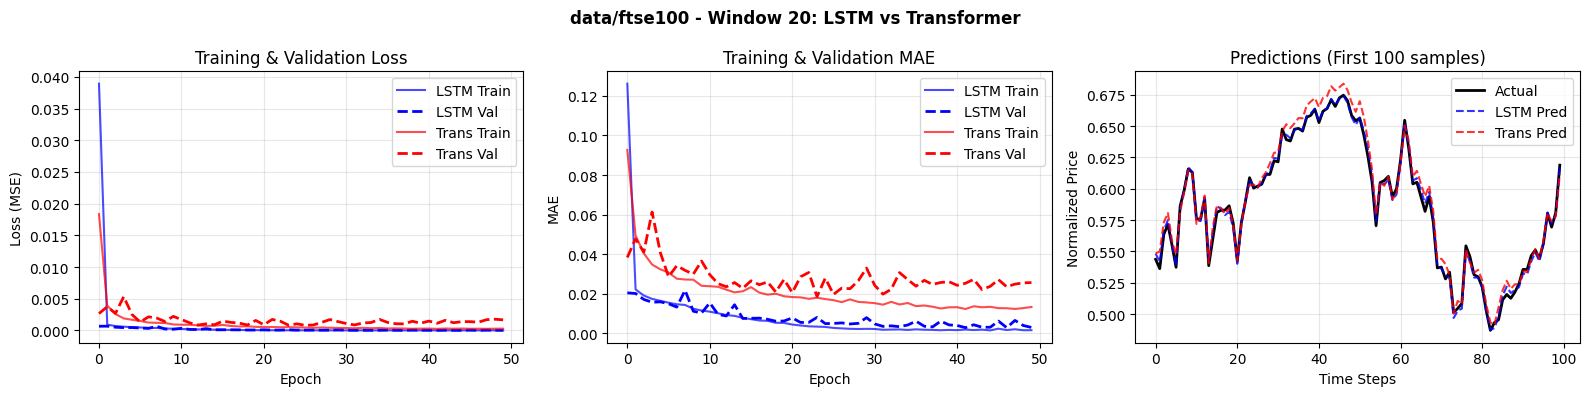

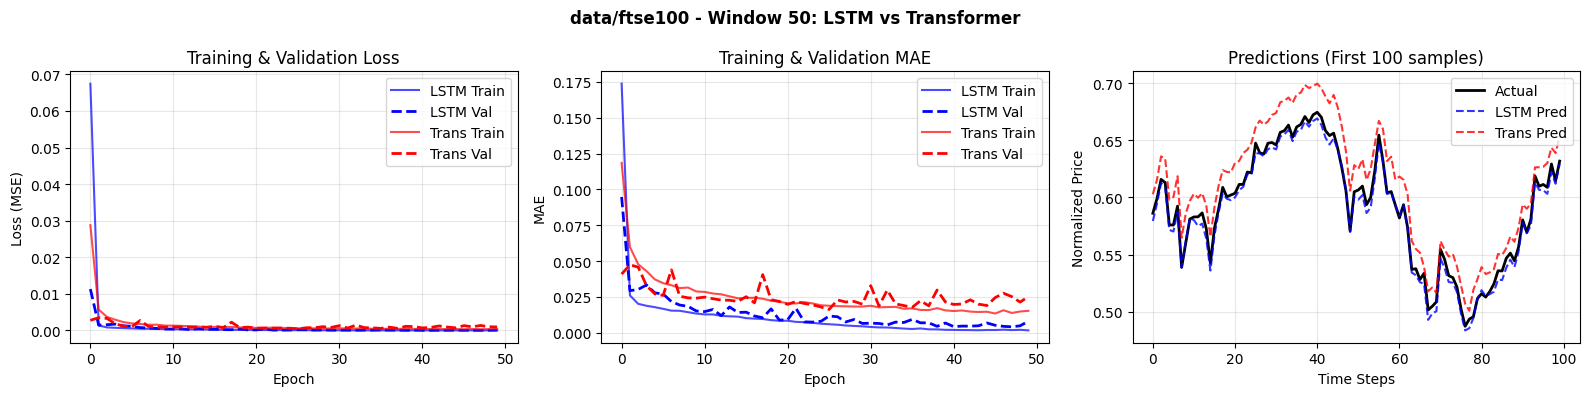

In [25]:
# Plot comparison for FTSE100 with different window sizes
for ws in windows:
    plot_training_comparison('data/ftse100', ws)

## 4. Summary Statistics

In [26]:
# Calculate average metrics
lstm_losses = []
trans_losses = []
lstm_maes = []
trans_maes = []

for stock in stocks:
    for ws in windows:
        lstm_loss, lstm_mae = get_final_metrics(lstm_results, stock, ws)
        trans_loss, trans_mae = get_final_metrics(transformer_results, stock, ws)
        
        if lstm_loss is not None:
            lstm_losses.append(lstm_loss)
            lstm_maes.append(lstm_mae)
        if trans_loss is not None:
            trans_losses.append(trans_loss)
            trans_maes.append(trans_mae)

print("=" * 50)
print("Summary Statistics")
print("=" * 50)
print(f"\nLSTM:")
print(f"  Average Val Loss: {np.mean(lstm_losses):.4f} ± {np.std(lstm_losses):.4f}")
print(f"  Average Val MAE:  {np.mean(lstm_maes):.4f} ± {np.std(lstm_maes):.4f}")
print(f"\nTransformer:")
print(f"  Average Val Loss: {np.mean(trans_losses):.4f} ± {np.std(trans_losses):.4f}")
print(f"  Average Val MAE:  {np.mean(trans_maes):.4f} ± {np.std(trans_maes):.4f}")

# Count wins
lstm_wins = sum(1 for l, t in zip(lstm_losses, trans_losses) if l < t)
trans_wins = len(lstm_losses) - lstm_wins

print(f"\n{'='*50}")
print(f"Winner count: LSTM {lstm_wins} vs Transformer {trans_wins}")
print(f"Overall winner: {'LSTM' if lstm_wins > trans_wins else 'Transformer'}")
print(f"{'='*50}")

Summary Statistics

LSTM:
  Average Val Loss: 0.0001 ± 0.0001
  Average Val MAE:  0.0056 ± 0.0027

Transformer:
  Average Val Loss: 0.0024 ± 0.0015
  Average Val MAE:  0.0344 ± 0.0109

Winner count: LSTM 9 vs Transformer 0
Overall winner: LSTM


## 5. Heatmap: Performance by Stock and Window Size

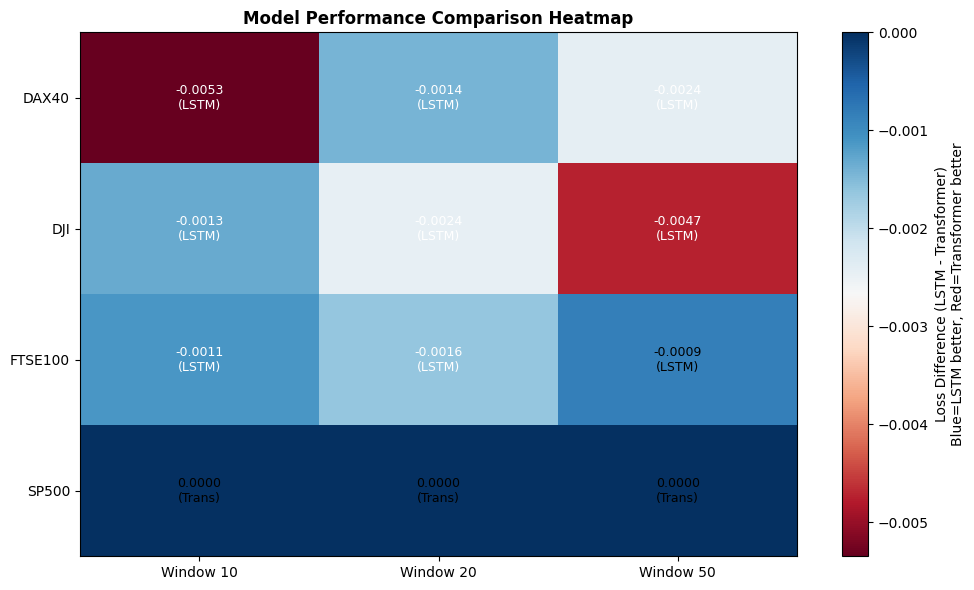

In [27]:
# Create heatmap data: difference (LSTM - Transformer), negative means LSTM is better
diff_matrix = np.zeros((len(stocks), len(windows)))
stock_labels = [s.split('/')[-1].upper() for s in stocks]

for i, stock in enumerate(stocks):
    for j, ws in enumerate(windows):
        lstm_loss, _ = get_final_metrics(lstm_results, stock, ws)
        trans_loss, _ = get_final_metrics(transformer_results, stock, ws)
        if lstm_loss is not None and trans_loss is not None:
            diff_matrix[i, j] = lstm_loss - trans_loss  # negative = LSTM better

fig, ax = plt.subplots(figsize=(10, 6))
im = ax.imshow(diff_matrix, cmap='RdBu', aspect='auto')

# Add labels
ax.set_xticks(range(len(windows)))
ax.set_xticklabels([f'Window {w}' for w in windows])
ax.set_yticks(range(len(stocks)))
ax.set_yticklabels(stock_labels)

# Add value annotations
for i in range(len(stocks)):
    for j in range(len(windows)):
        val = diff_matrix[i, j]
        winner = 'LSTM' if val < 0 else 'Trans'
        text = ax.text(j, i, f'{val:.4f}\n({winner})', ha='center', va='center', 
                      color='white' if abs(val) > 0.001 else 'black', fontsize=9)

plt.colorbar(im, label='Loss Difference (LSTM - Transformer)\nBlue=LSTM better, Red=Transformer better')
plt.title('Model Performance Comparison Heatmap', fontsize=12, fontweight='bold')
plt.tight_layout()
plt.show()